<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/ResNet18_LRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import timm
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
import os

In [ ]:
model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = timm.create_model(model_name, pretrained=True)
model.eval()
model = model.to(device)

cuda


In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

image_dir = 'cat/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

input_tensor = input_tensor.to(device)
batch_size = input_tensor.shape[0]

1000
Input tensor shape: torch.Size([8, 3, 224, 224])


In [ ]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

target = torch.eye(1000, device=device)[[0]].repeat(batch_size, 1)

with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(input_tensor, target)

torch.Size([8, 3, 224, 224])
(8, 224, 224)


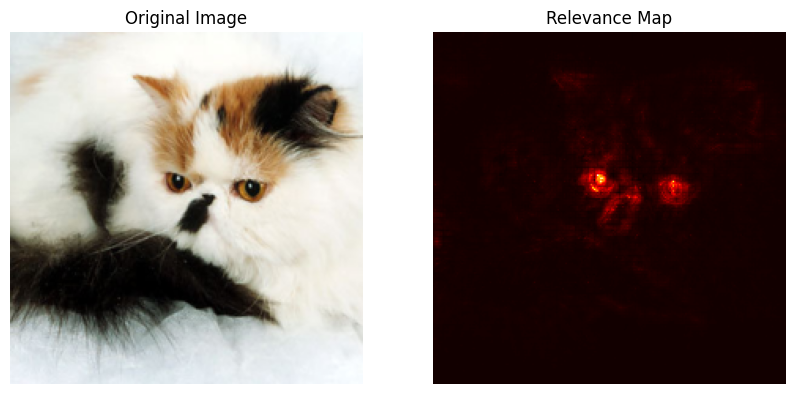

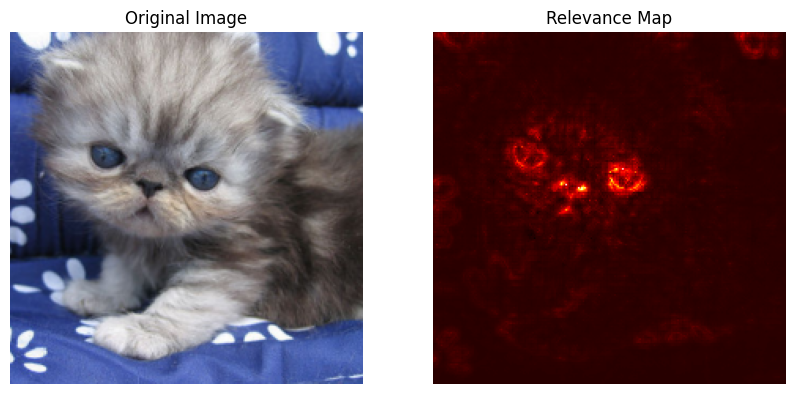

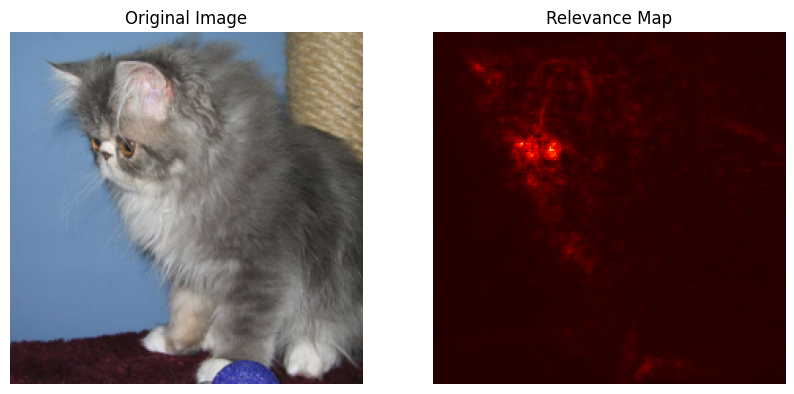

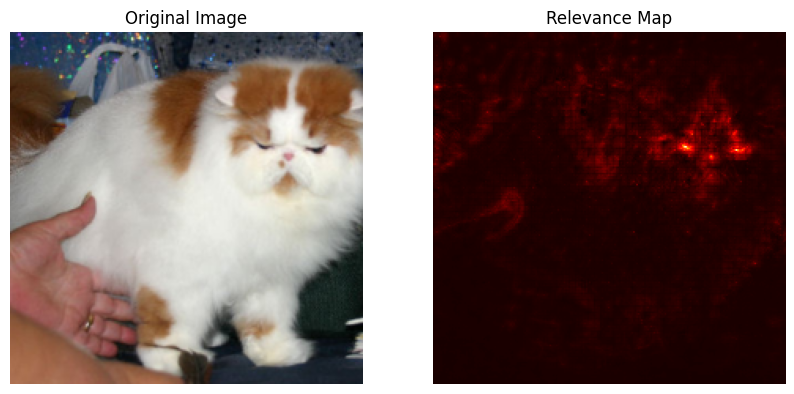

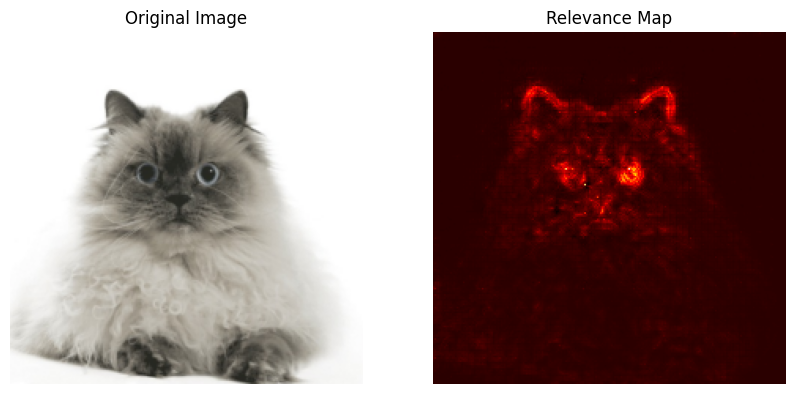

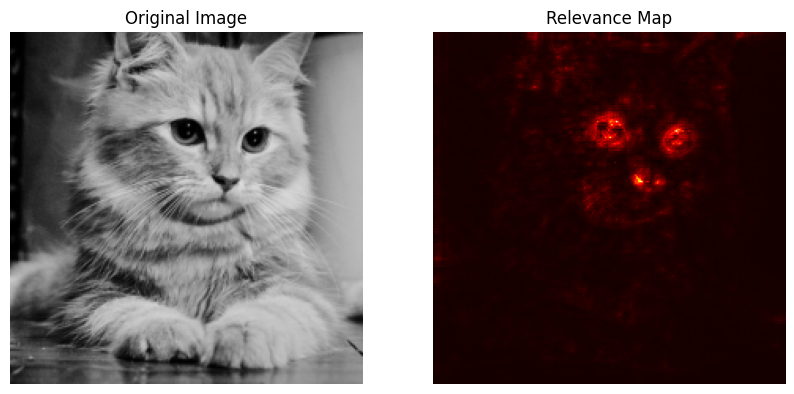

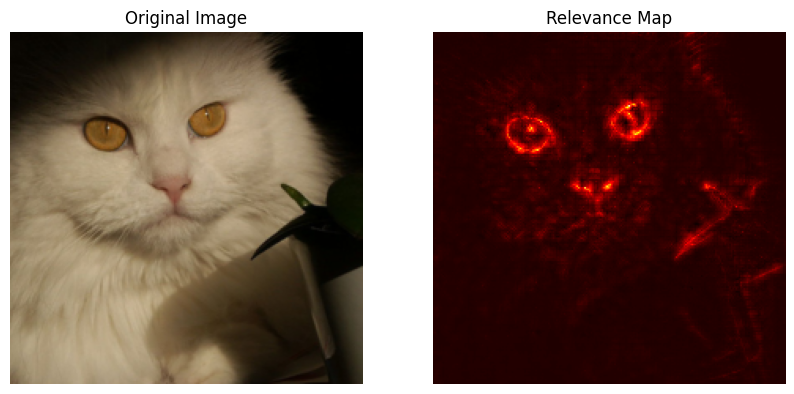

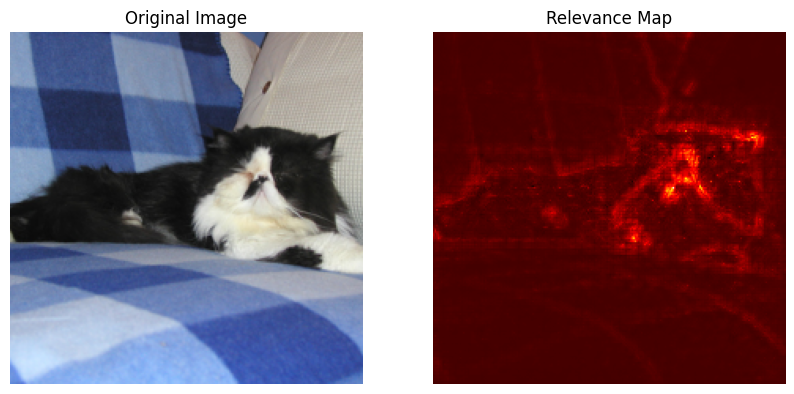

In [ ]:
import matplotlib.pyplot as plt

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

relevance_norm = 'symmetric'
# normalize between 0. and 1. given the specified strategy
if relevance_norm == 'symmetric':
    # 0-aligned symmetric relevance, negative and positive can be compared, the original 0. becomes 0.5
    amax = np.abs(rel).max((1, 2), keepdims=True)
    rel = (rel + amax) / 2 / amax
elif relevance_norm == 'absolute':
    # 0-aligned absolute relevance, only the amplitude of relevance matters, the original 0. becomes 0.
    rel = np.abs(rel)
    rel /= rel.max((1, 2), keepdims=True)
elif relevance_norm == 'unaligned':
    # do not align, the original minimum value becomes 0., the original maximum becomes 1.
    rmin = rel.min((1, 2), keepdims=True)
    rmax = rel.max((1, 2), keepdims=True)
    rel = (rel - rmin) / (rmax - rmin)

for i in range(batch_size):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i])
    plt.title("Original Image")

    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rel[i], cmap='hot', alpha=1)
    plt.title("Relevance Map")
    plt.axis('off')
    plt.show()